In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import networkx as nx
import networkx.algorithms.bipartite as bipartite
from multiprocessing import Pool
import itertools
from collections import Counter
import sys
sys.path.append('lib/')
from degree_seq_bipartite import bipartite_degree_seq


Micorscopic cavity dynamics:
\begin{eqnarray}
v_i& \equiv \langle n_i\rangle =  1-\prod_{\mu \in\partial _i}\left(1-m_\mu^{(i)}\right)\\
m_\mu^{(i)}&\equiv\langle \tau_\mu^{(i)}\rangle = 1-\prod_{j\in\partial _\mu\setminus i}\left(1-p_{j\mu}v_j^{(\mu)}\right)\\
v_j^{(\mu)}& \equiv\langle n_j^{(\mu)}\rangle = 1-\prod_{\nu\in\partial _j\setminus \mu }\left(1-m_\nu^{(j)}\right)\\
\end{eqnarray}
In the following I label ``a`` the quantities that refers to individuals, ``b`` for the clusters

In [160]:
N_a = 10_000# n people
N_b = 5_000 #n clusters
a_mean = 2 #average degree of the distribution
#b_mean = (a_mean )* N_a / N_b 
aseq,bseq = bipartite_degree_seq(N_a,N_b,'shifted_poisson','shifted_poisson',{'lam':a_mean},{'lam':N_a*a_mean/N_b})
BG = bipartite.generators.configuration_model(aseq,bseq)
BG = nx.Graph(BG)#convert multilinks to simple 
#G = nx.algorithms.bipartite.projection.projected_graph(BG,range(N_a,N_b))#projection on the cluster layer
p = 0.6 #probability to have a link
min(bseq),min(aseq)

{'lam': 2}


(1, 1)

In [174]:
def Convert(tup, di={}):
    ''' for undirected edges. I construct the neighbouring relationship.
    Returns:
        di: dictionary.
    Notes:
    For link (a,b)  it returns the di[a]+=[b], and di[b]+=[a]
    '''
    for a, b in tup: 
        di.setdefault(a, []).append(b)
        di.setdefault(b, []).append(a)
    di = {key:np.array(value) for key, value in di.items()}
    return di 
neigh = Convert(BG.edges())
states = {key:np.ones(len(value)) for key,value in neigh.items()}#states[x][y] indicates the state of node "x cavity neigh[x][y]""

Below the single instance cavity is computed

In [175]:
N_iterations = 5
for count in range(N_iterations):    #solving cavity equations through forward dynamics
    for j in range(N_a):#solving 3rd equation
            for idx,mu in enumerate(neigh[j]):
                new=1
                for nu in set(neigh[j])-{mu}:
                    new*=(1-states[nu][neigh[nu]==j])
                states[j][idx]= 1-new
    for mu in range(N_a,N_a+N_b): #running 2nd equation
            for idx,i in enumerate(neigh[mu]):
                new=1
                for j in set(neigh[mu])-{i}:
                    new*=(1-p*states[j][neigh[j]==mu])
                states[mu][idx]= 1-new
risk ={}
for i in range(N_a):#solving 3rd equation
    new=1
    for mu in set(neigh[i]):
        new*=(1-states[mu][neigh[mu]==i])
    risk[i]= 1-new


Text(0.5, 1.0, '10000 inh., 5000 clusters, <cluster size> = 4.0, p=0.6')

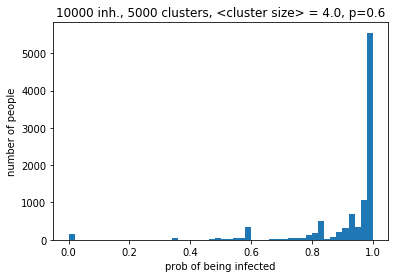

In [176]:
#plt.hist([x for el in states.values() for x in el],bins = 50)
plt.hist([x for el in risk.values() for x in el],bins = 50)
plt.xlabel('prob of being infected')
plt.ylabel('number of people')
plt.title(str(N_a)+' inh., '+str(N_b)+' clusters, <cluster size> = '+str(N_a*a_mean/N_b)+', p=' + str(p))
#plt.savefig('single_instance.pdf')